In [21]:
import numpy as np
import descent
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.style.use(['ocean', 'seaborn-notebook'])
from functools import partial
%matplotlib inline

In [22]:
import sklearn
from sklearn.datasets import make_regression

# Sparse linear regression

We first generate a toy problem instance:

In [25]:
A, y, x = make_regression(n_samples=20, n_features=50, n_informative=5, coef=True, random_state=1234)

We wish to solve the following:
$$ \text{minimize} \quad \| y-Ax \|_2^2 + \lambda \|x\|_1 $$ 

<Container object of 3 artists>

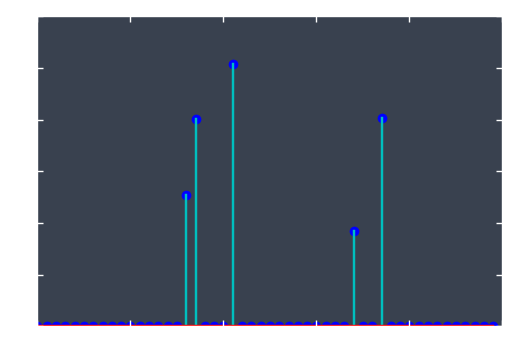

In [26]:
# here is the ground truth sparse vector
plt.stem(x, 'c-')

## Least squares solution

What happens if we solve the system without the sparsity penalty?

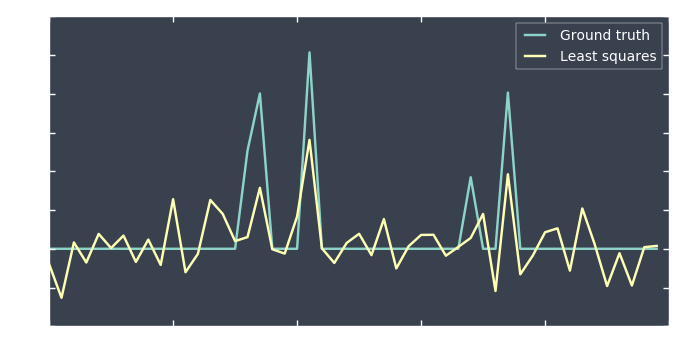

In [27]:
# compute the least squares solution
x_lsq = np.linalg.lstsq(A, y)[0]

# plot the results
plt.figure(figsize=(8,4))
plt.plot(x, '-')
plt.plot(x_lsq)
plt.legend(['Ground truth', 'Least squares'])

## Subgradient descent

One way to solve this problem is to go ahead and do gradient descent, using subgradients for the non-smooth term

In [28]:
# squared error objective
def f_df(x):
    err = A.dot(x) - y
    objective = 0.5 * np.linalg.norm(err) ** 2
    gradient = A.T.dot(err)
    return objective, gradient

# squared error + sparsity penalty
def f_df_sparse(x, penalty=1.0):
    # squared error
    obj, grad = f_df(x)
    
    # tack on the sparsity penalty
    obj_sparse = obj + penalty * np.linalg.norm(x, 1)
    grad_sparse = grad + penalty * np.sign(x)
    
    return obj_sparse, grad_sparse

In [29]:
opt_subg = descent.sgd(0.01).minimize(f_df_sparse, x_lsq, display=None, maxiter=1e4)

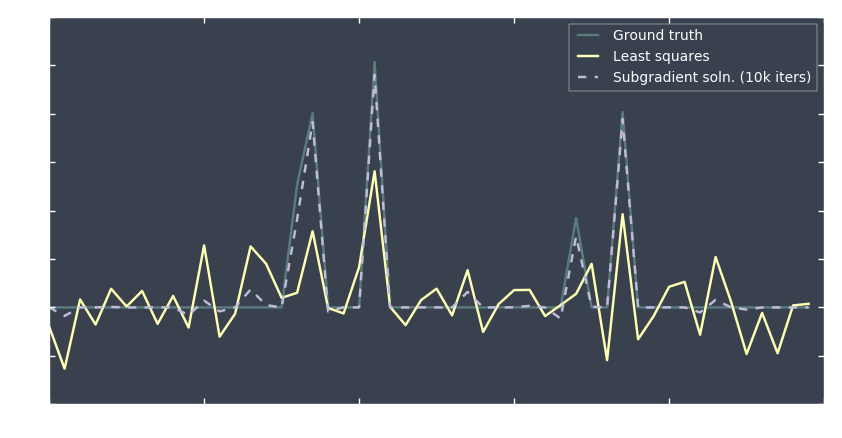

In [30]:
plt.figure(figsize=(10,5))
plt.plot(x, '-', alpha=0.4)
plt.plot(x_lsq, '-')
plt.plot(opt_subg.x, '--')
plt.legend(['Ground truth', 'Least squares', 'Subgradient soln. (10k iters)'])

## ADMM / Proximal methods

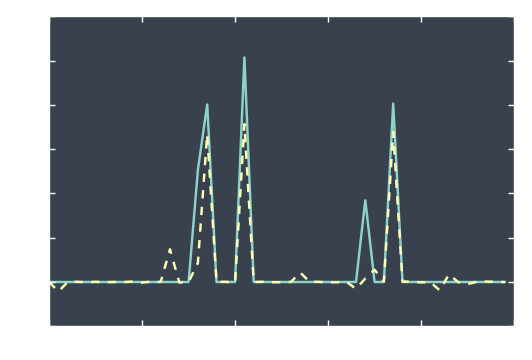

In [36]:
opt_admm = descent.Consensus()
opt_admm.add('linsys', A, y)
opt_admm.add('sparse', 100.0)
res = opt_admm.minimize(x_lsq, maxiter=1000, display=None)
plt.plot(x, '-')
plt.plot(res.x, '--')

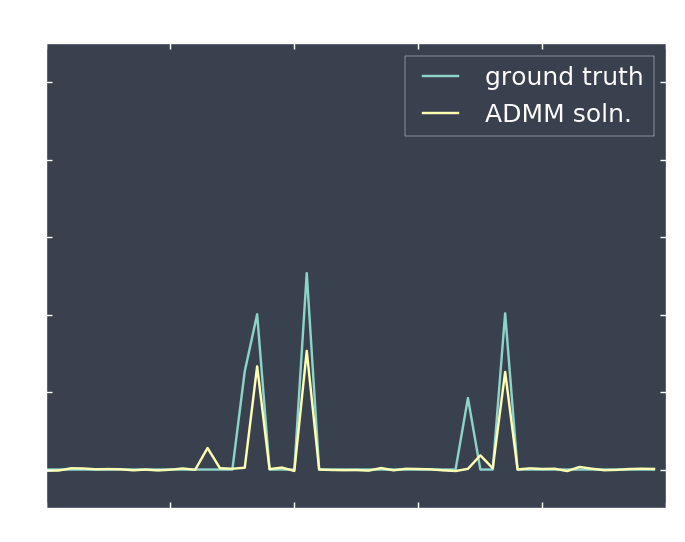

In [37]:
@interact(penalty=(10., 500., 100), maxiter=(20, 100, 20))
def solve_sparsereg(penalty=1., maxiter=100):
    opt_admm = descent.Consensus(tau=(2., 1., 1.))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    res = opt_admm.minimize(x_lsq, maxiter=maxiter, display=None)
    
    plt.figure(figsize=(8,6))
    plt.title('$\lambda = {}$, run for {} iterations'.format(penalty, maxiter), fontsize=24)
    plt.plot(x)
    plt.plot(res.x, '-')
    plt.ylim(-10, 110)
    plt.legend(['ground truth', 'ADMM soln.'], fontsize=18, loc='upper right')